In [179]:
from collections import defaultdict
import argparse
import numpy as np
from tqdm.auto import trange
import ray

import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

In [216]:
dist[10]

array([0.06901656, 0.52315469])

In [182]:
dist = np.random.uniform(0, 1, (10000, 2))

In [230]:
# ray.init()

# @ray.remote
class NeutralModel():
    def __init__(self, N=10, S=30, mu=0.3, k=0.2, p=100000, t=10) -> None:
        # lookup tables for the types
        self.frequency_lookup = defaultdict(int)
        # self.meaning_lookup = defaultdict(int)
        self.age_lookup = defaultdict(int)
        self.sense_lookup = defaultdict(list)

        self.N = N # number of types
        self.S = S # number of meanings
        self.mu = mu # rate of invention/borrowing
        self.k = k # rate of reuse
        self.p = int(p) # size of sample of tokens
        self.t = t # number of time steps

        self.initialize()

    def initialize(self):
        # initialize the meanings and frequencies
        for _ in range(self.N):
            rt = np.random.randint(0, 10**6)
            # self.meaning_lookup[rt] = 1
            self.age_lookup[rt] = 0
            # randomly sample from dist 
            self.sense_lookup[rt].append(dist[np.random.choice(dist.shape[0])])

        # initailize the pool
        self.pool = np.random.choice(list(self.sense_lookup.keys()), size=self.p, replace=True)
        
        # get list of all coordinates from sense_lookup
        coordinates = []
        for rt in self.sense_lookup:
            coordinates.extend(self.sense_lookup[rt])

        # while sum(self.meaning_lookup.values()) < self.S:
        # while sum of lengths of lists in sense_lookup < self.S:
        while len(coordinates) < self.S:
            new_w = np.random.choice(self.pool)
            initial_meaning = self.sense_lookup[new_w]
            closest_meanings = cdist(np.array(initial_meaning), dist)
            print(np.array(initial_meaning))
            closest_meanings = dist[np.argsort(closest_meanings)][:10]
            new_meaning = closest_meanings[np.random.choice(closest_meanings.shape[0])]
            self.sense_lookup[new_w].append(new_meaning)

    def step(self, t):
        # clean frequency lookup
        frequency_lookup = defaultdict(int)

        # randomly sample from pool using numpy
        self.pool = np.random.choice(self.pool, size=self.p, replace=True)

        # NB: invention applies to the pool (i.e. to the list of size p)
        invent_index = np.where(np.random.binomial(1, self.mu, size=self.p) == 1)[0]

        # adding new forms
        for i in invent_index:
            rt = np.random.randint(0, 10**6)
            self.sense_lookup[rt].append(dist[np.random.choice(dist.shape[0])])
            self.age_lookup[rt] = 1
            self.pool[i] = rt
        
        # update frequency_lookup using numpy
        unique_types, counts = np.unique(self.pool, return_counts=True) 
        for rt, count in zip(unique_types, counts):
            frequency_lookup[rt] = count
        
        # NB: reuse applies to the list of types
        reuse_index = np.where(np.random.binomial(1, self.k, size=len(unique_types)) == 1)[0]  
        for i in reuse_index:
            # self.meaning_lookup[unique_types[i]] += 1
            # add a new sense by samplign 10 closest meanings from dist
            new_meaning = get_top_10_coordinates(dist, self.sense_lookup[unique_types[i]][0])
            self.sense_lookup[unique_types[i]].append(new_meaning)
        
        # remove types that are not in the pool from meaning_lookup
        for rt in list(self.meaning_lookup.keys()):
            if rt in unique_types:
                self.age_lookup[rt] += 1
                self.history.append({
                        'step': t,
                        'id': rt,
                        'age': self.age_lookup[rt],
                        'count': frequency_lookup[rt],
                        'meanings': len(self.sense_lookup[rt]),
                        'extinct': 0
                    })
            else:
                self.history.append({
                    'step': t,
                    'id': rt,
                    'age': self.age_lookup[rt],
                    'count': frequency_lookup[rt],
                    'meanings': len(self.sense_lookup[rt]),
                    'extinct': 1
                })
                del self.meaning_lookup[rt]
                del self.age_lookup[rt]
        
    def run(self):
        print(f'Initializing the model with N={self.N}, S={self.S}, mu={self.mu}, k={self.k}, p={self.p}, t={self.t} ...')
        self.history = []
        name = f'data/model-data/model-N{self.N}_S{self.S}_p{self.p}.csv'

        for t in trange(self.t, 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}',
                desc='Running the model', 
                position=0, 
                leave=True):
            self.step(t)

        with open(name, 'w') as f:
            f.write('step,id,age,count,meanings,extinct \n')
            for row in self.history:
                f.write(f"{row['step']},{row['id']},{row['age']},{row['count']},{row['meanings']},{row['extinct']}\n")

In [231]:
# model = NeutralModel.remote(N=250, S=500, mu=0.01, k=0.1, p=10000, t=300)
# ray.get(model.run.remote())
# ray.shutdown()
model = NeutralModel(N=250, S=500, mu=0.01, k=0.1, p=10000, t=300)
model.run()

[[0.09644168 0.34716743]]
[[0.68180878 0.23175542]]
[[0.62685981 0.18791449]]
[[0.54055546 0.36394382]]
[[0.93441492 0.45516159]]
[[0.01174316 0.05929828]]
[[0.29833801 0.8506045 ]]
[[0.13063766 0.71290619]]
[[0.84031652 0.27450363]]
[[0.91505224 0.15712804]]
[[0.96176536 0.12380014]]
[[0.95361928 0.19683371]]
[[0.83363699 0.41554127]]
[[0.82512267 0.63168869]]
[[0.99755319 0.6380059 ]]
[[0.01381926 0.41118441]]
[[0.92670974 0.20108244]]


/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_49802/1529721765.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  closest_meanings = cdist(np.array(initial_meaning), dist)


ValueError: XA must be a 2-dimensional array.

In [163]:
res = pd.read_csv('data/model-data/model-N2500_S5000_p100000.csv')

In [164]:
res_ = res[res['step'] == max(res['step'])]
# convert count to frequency in res_['count']
res_['freq'] = res_['count'] / res_['count'].sum()

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_49802/2783852821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_['freq'] = res_['count'] / res_['count'].sum()


Text(0, 0.5, 'Average age')

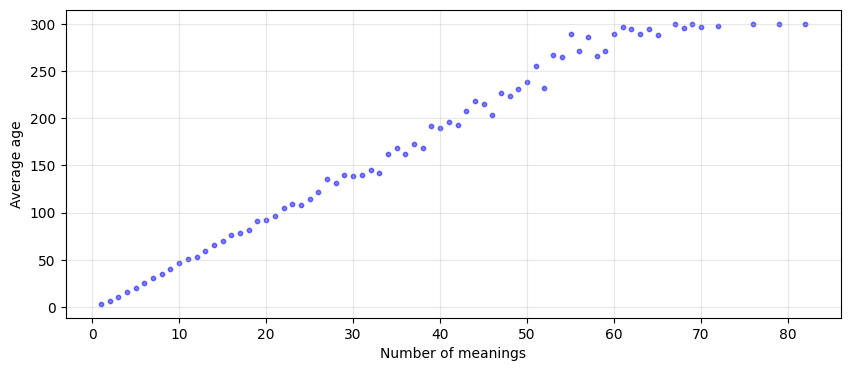

In [165]:
plt.figure(figsize=(10, 4))
plt.grid(alpha = 0.3)
# plt.scatter(res_['age'], res_['meanings'], s = 10, color = 'blue', alpha = 0.5)
# compute average age per each number of meanings
res_ = res_.groupby('meanings').mean().reset_index()
# add confidence interval
plt.scatter(res_['meanings'], res_['age'], s = 10, color = 'blue', alpha = 0.5)
plt.xlabel('Number of meanings')
plt.ylabel('Average age')

In [166]:
res_

,meanings,step,id,age,count,extinct,freq
0,1,299.0,493631.316071,3.669133,1.824908,0.213728,0.000018
1,2,299.0,497362.858374,6.495690,3.167488,0.162562,0.000032
2,3,299.0,495137.197105,10.746102,5.051225,0.094655,0.000051
3,4,299.0,488389.806122,16.343537,7.957483,0.068027,0.000080
4,5,299.0,525527.306604,20.726415,9.674528,0.070755,0.000097
...,...,...,...,...,...,...,...
68,70,299.0,636772.833333,296.333333,54.333333,0.000000,0.000543
69,72,299.0,601727.250000,297.500000,23.500000,0.000000,0.000235
70,76,299.0,259229.000000,300.000000,30.000000,0.000000,0.000300
71,79,299.0,290217.000000,300.000000,64.000000,0.000000,0.000640


Text(0, 0.5, 'Average frequency')

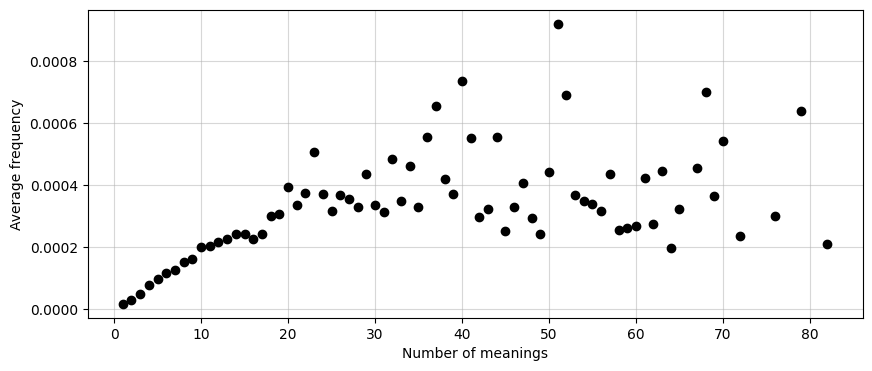

In [167]:
plt.figure(figsize=(10, 4))
plt.grid(alpha = 0.5)
plt.plot(res_['meanings'], res_['freq'], 'o', color = 'black', label = 'mean frequency')
plt.xlabel('Number of meanings')
plt.ylabel('Average frequency')